In [1]:
%matplotlib widget
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import math
from scipy.signal import find_peaks
sys.path.insert(0, '../resurfemg')
import helper_functions as hf
from config import Config

In [2]:
# get new changes in our library i.e. the tmsisdk
import sys
sys.path.insert(0, '../resurfemg')

from tmsisdk_lite import Poly5Reader

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


In [3]:



def smooth_for_baseline(single_filtered_array, threshold=10, start=None, end=None, smooth=100):
    """
    This is an adaptive smoothing that overvalues closer numbers.
    """
    
    array = single_filtered_array[start:end]
    #overlay = np.zeros(len(array)).astype('int8')
    dists = np.zeros(len(array))
    print(len(array), array.max(), array.min())
    wmax, wmin = 0, 0
    nwmax, nwmin = 0, 0
    count, filler = 0, False
    tail = (smooth - 1) / smooth
    switched = 0

    for i, elt in enumerate(array[1:]):
        if elt > 0:
            nwmax = wmax * tail + elt / smooth
        else:
            nwmin = wmin * tail + elt / smooth
        dist = nwmax - nwmin
        odist = wmax - wmin
        if (i > smooth) and (i - switched > smooth):
            vodist = dists[i - smooth]
            if (vodist / dist > threshold) or (dist / vodist > threshold):
                filler = not filler
                count += 1
                switched = i
        #overlay[i] = filler
        dists[i] = dist
        wmax, wmin = nwmax, nwmin
    return array, dists


In [4]:
config = Config()
root_emg_directory = config.get_directory('root_emg_directory')

In [5]:
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)

# # print an example from the list
# print(emg_files[1],draeger_files[1])

In [6]:
list_of_numbers_strung = []
for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value='0',
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '1…

In [7]:
number_chosen = int(btn.value)
file_chosen = emg_files[number_chosen] 
print(file_chosen)

C:/Projects/ReSurfEMG/not_pushed/topspin_data_anonymized\M001\001\EMG_recording.Poly5


Reading file  C:/Projects/ReSurfEMG/not_pushed/topspin_data_anonymized\M001\001\EMG_recording.Poly5
	 Number of samples:  172576 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.


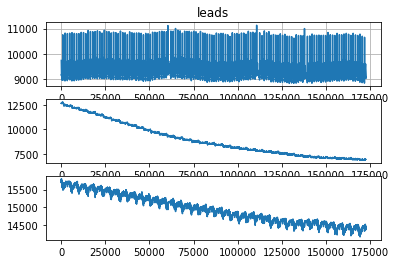

In [8]:
# get the poly5 reading
data_emg = Poly5Reader(file_chosen)
data_samples= data_emg.samples
%matplotlib inline
# set up plot
x = data_samples
fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
ax_1.grid(True)
ax_1.plot(x[0])
ax_1.set(title='leads')
ax_2.plot(x[1])
ax_3.plot(x[2])


In [9]:
def working_pipeline_exp2_abs(our_chosen_file): 
    cut_file_data = hf.bad_end_cutter_for_samples(our_chosen_file, percent_to_cut=3, tolerance_percent=5)
    bd_filtered_file_data = hf.emg_bandpass_butter_sample(cut_file_data, 5, 450, 2048, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = hf.bad_end_cutter_for_samples(bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    # skip step4 and do step 5 ICA
    components = hf.compute_ICA_two_comp(re_cut_file_data)
    #     the secret hidden step!
    emg= hf.pick_more_peaks_array(components)
    # now process it in final steps
    abs_values = abs(emg)
    final_envelope_d = hf.emg_highpass_butter(abs_values, 150, 2048)
    #final_envelope_a = helper_functions.naive_rolling_rms(final_envelope_d, 300)
    #plt.plot(final_envelope_a[0:5000])
    
    abs_final_values = abs(final_envelope_d)   
    return abs_final_values

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


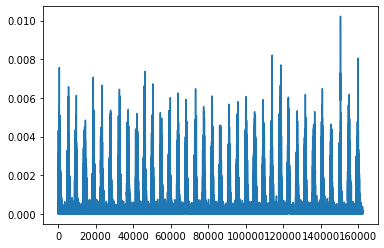

In [10]:
x = data_samples
our_array = working_pipeline_exp2_abs(x)
plt.plot(our_array)

In [11]:
array , dists= smooth_for_baseline(our_array, threshold=10, start=None, end=None, smooth=100)

162376 0.010223440193782178 1.7961972371982344e-09


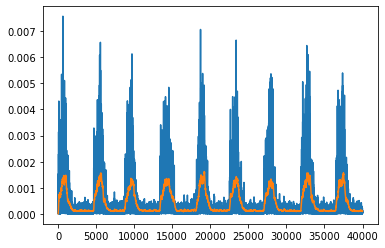

In [12]:


plt.plot(array[:40000])
plt.plot(dists[:40000])
#plt.plot(overlay[:40000])

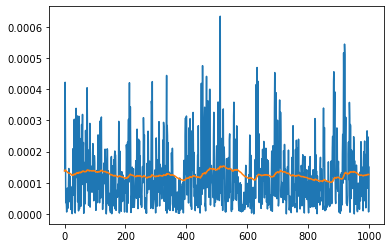

In [13]:
plt.plot(array[3000:4000])
plt.plot(dists[3000:4000])

Now plot the troughts on the array- which  will be an adaptive baseline

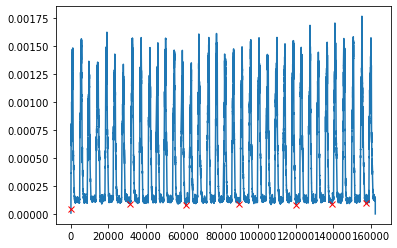

In [14]:
antipeaks1, anti_1 = find_peaks((dists*(-1)),distance = 17000) # 17,000 seems to capture every certain number of breaths the nadir- great

plt.plot(dists)
#plt.plot(peaks0, x[peaks0],"x")
plt.plot(antipeaks1, dists[antipeaks1],"x", color= 'red')
#plt.show()

So now we have an array of baseline values (dists[antipeaks1]). What do we mean when we claim something is more than the baseline?

This must be defined mathematically by the you guys, and then can be programmed.